# Machine-Learning for DDOS attack detection
*Ayman BEN HAJJAJ & Jules RUBIN*

## Description
This study is the final project of the Machine-Learning II course at EFREI Paris (Master 1 Data Science & AI 2023).
This project aims to detect DDOS attacks in a network using machine learning. The dataset used is the [CIC-DDoS2019](https://www.kaggle.com/datasets/dhoogla/cicddos2019) dataset. This dataset contains 78 features and 430K rows. The dataset contains 18 types of attacks. The goal is to detect the attacks using machine learning.
The taxonomy of attacks present in the dataset are described in the research paper [DDoS Evaluation Dataset (CIC-DDoS2019)](https://www.unb.ca/cic/datasets/ddos-2019.html).

**Taxonomy of attacks present in the dataset:**

![Taxonomy of attacks](https://www.unb.ca/cic/_assets/images/ddostaxonomy.png)

As we have the choice on the type of attack to detect, we will focus on the detection of 3 types of attacks:
- UDP : UDP Flood attack
- Syn : Syn Flood attack
- DrDoS DNS : DNS amplification attack

We will also provide a method that can classify the benign traffic from the malicious traffic.

## Preprocessing

### Importing libraries and dataset

In [217]:
# making the necessary imports
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [218]:
df = pd.DataFrame()
df = pd.concat([df, pd.read_parquet('data/Syn-training.parquet')])
df = pd.concat([df, pd.read_parquet('data/DNS-testing.parquet')])
df = pd.concat([df, pd.read_parquet('data/UDP-training.parquet')])
df['Label'].value_counts()

Syn          43302
Benign       32901
UDP          14792
DrDoS_DNS     3669
MSSQL          145
Name: Label, dtype: int64

In [219]:
# We can remove the MSSQL data as it is not required for our analysis
df = df[df['Label'] != 'MSSQL']

In [220]:
df['Label'].value_counts()

Syn          43302
Benign       32901
UDP          14792
DrDoS_DNS     3669
Name: Label, dtype: int64

### Data cleaning

#### Dealing with missing values

In [221]:
# count the number of missing values in each column
df.isnull().sum().sort_values(ascending=False)

Protocol                0
CWE Flag Count          0
Fwd Avg Packets/Bulk    0
Fwd Avg Bytes/Bulk      0
Avg Bwd Segment Size    0
                       ..
Bwd IAT Total           0
Fwd IAT Min             0
Fwd IAT Max             0
Fwd IAT Std             0
Label                   0
Length: 78, dtype: int64

#### Dealing with outliers

In [222]:
# check for duplicate rows
df.duplicated().sum()

194

In [223]:
# remove duplicate rows
df.drop_duplicates(inplace=True)

We do not have any missing values in the dataset. However, we have some duplicates. We will remove them.

#### Dealing with categorical variables

In [224]:
# count the number of unique values in each column
df.nunique().sort_values(ascending=True).head(25)

Bwd Avg Bulk Rate          1
Bwd Avg Packets/Bulk       1
Bwd Avg Bytes/Bulk         1
Fwd Avg Bulk Rate          1
Fwd Avg Packets/Bulk       1
Fwd Avg Bytes/Bulk         1
ECE Flag Count             1
Fwd URG Flags              1
Bwd PSH Flags              1
Bwd URG Flags              1
PSH Flag Count             1
FIN Flag Count             1
URG Flag Count             2
Fwd PSH Flags              2
RST Flag Count             2
ACK Flag Count             2
CWE Flag Count             2
SYN Flag Count             2
Protocol                   3
Label                      4
Down/Up Ratio             15
Bwd IAT Min              105
Bwd Packet Length Min    195
Fwd Act Data Packets     212
Total Fwd Packets        263
dtype: int64

As some columns has only one unique value, they do not bring any information. We will remove them.
We can also see that some columns are categorical variables. We will convert them to numerical variables using the OneHotEncoder.

In [225]:
one_value_cols = [col for col in df.columns if df[col].nunique() <= 1]
df = df.drop(one_value_cols, axis=1)

In [226]:
three_value_cols = [col for col in df.columns if df[col].nunique() <= 3]
# One Hot Encoding
df = pd.get_dummies(df, columns=three_value_cols)

### Balancing the dataset

In [227]:
df['Label'].value_counts()

Syn          43302
Benign       32707
UDP          14792
DrDoS_DNS     3669
Name: Label, dtype: int64

In [228]:
# As the dataset is imbalanced, we will balance it by taking 3000 samples from each class
balanced = pd.DataFrame()
balanced = pd.concat([balanced, df[df['Label'] == 'Syn'].sample(n=3500)])
balanced = pd.concat([balanced, df[df['Label'] == 'DrDoS_DNS'].sample(n=3500)])
balanced = pd.concat([balanced, df[df['Label'] == 'UDP'].sample(n=3500)])
balanced = pd.concat([balanced, df[df['Label'] == 'Benign'].sample(n=3500)])
df = balanced.copy()
# free up memory
del balanced

### Handling outliers

In [229]:
df.describe()

,Flow Duration,Total Fwd Packets,Total Backward Packets,Fwd Packets Length Total,Bwd Packets Length Total,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,...,SYN Flag Count_0,SYN Flag Count_1,RST Flag Count_0,RST Flag Count_1,ACK Flag Count_0,ACK Flag Count_1,URG Flag Count_0,URG Flag Count_1,CWE Flag Count_0,CWE Flag Count_1
count,1.400000e+04,14000.000000,14000.000000,1.400000e+04,1.400000e+04,14000.000000,14000.000000,14000.000000,14000.000000,14000.000000,...,14000.000000,14000.000000,14000.000000,14000.000000,14000.000000,14000.000000,14000.000000,14000.000000,14000.000000,14000.000000
mean,1.402982e+07,8.086143,4.374143,2.376590e+03,3.189486e+03,399.491577,341.284058,355.151489,20.216715,90.585068,...,0.999500,0.000500,0.968500,0.031500,0.695286,0.304714,0.895714,0.104286,0.944500,0.055500
std,2.730984e+07,61.044469,81.280941,8.931430e+04,1.351280e+05,552.766052,486.063080,482.856781,70.979042,419.951080,...,0.022356,0.022356,0.174671,0.174671,0.460303,0.460303,0.305642,0.305642,0.228962,0.228962
min,1.000000e+00,1.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.900000e+01,2.000000,0.000000,6.000000e+01,0.000000e+00,6.000000,6.000000,6.000000,0.000000,0.000000,...,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000
50%,1.055245e+05,4.000000,0.000000,7.500000e+02,0.000000e+00,355.000000,47.000000,139.944443,0.000000,0.000000,...,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000
75%,7.145797e+06,6.000000,2.000000,2.088000e+03,2.400000e+01,426.000000,330.000000,359.500000,22.516661,6.000000,...,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000
max,1.199956e+08,4648.000000,8029.000000,1.054386e+07,1.289243e+07,24820.000000,1472.000000,2557.327393,1394.108276,3621.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


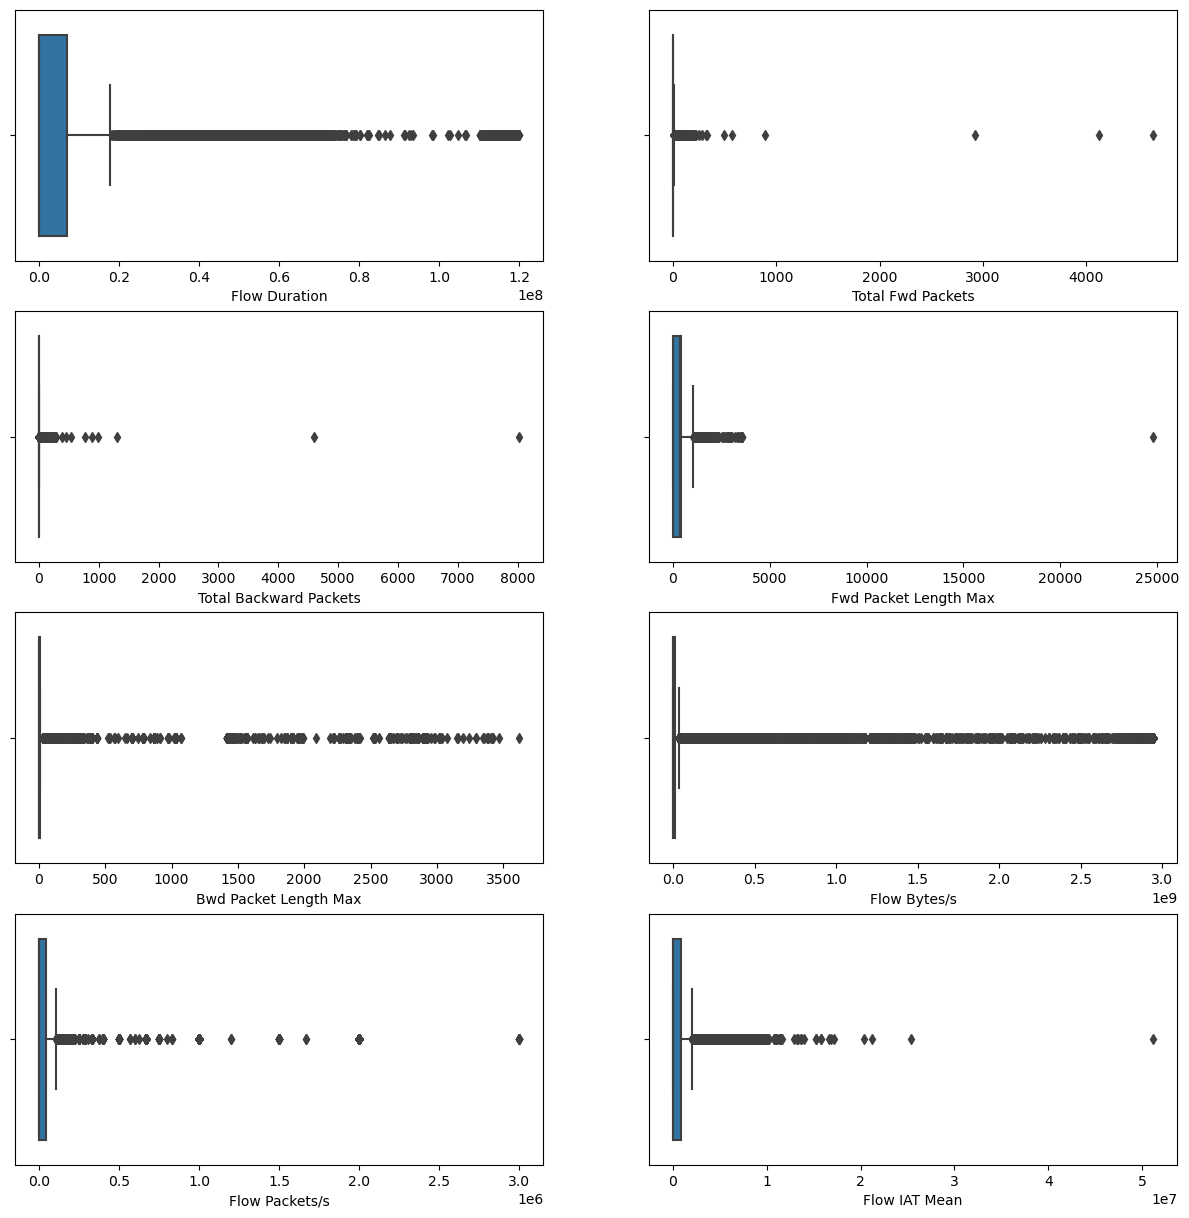

In [230]:
# check for the outliers
fig, ax = plt.subplots(4, 2, figsize=(15, 15))
# create a list of columns to check for outliers
outliers_col = ['Flow Duration', 'Total Fwd Packets', 'Total Backward Packets', 'Fwd Packet Length Max',
                'Bwd Packet Length Max', 'Flow Bytes/s', 'Flow Packets/s', 'Flow IAT Mean', 'Flow IAT Std']
                

# create a for loop to iterate over the columns
for i in range(0, 4):
    for j in range(0, 2):
        col = outliers_col[i * 2 + j]
        # create a boxplot for each column
        sns.boxplot(x=df[col], ax=ax[i, j])
plt.show()

In [231]:
# remove the outliers using IsolationForest
from sklearn.ensemble import IsolationForest

# create an instance of the IsolationForest class
iso = IsolationForest(n_estimators=1000, max_samples='auto', contamination=float(0.05), max_features=1.0,
                        bootstrap=False, n_jobs=-1, random_state=42, verbose=0)
# fit the model
yhat = iso.fit_predict(df.drop('Label', axis=1))
# select all rows that are not outliers
mask = yhat != -1
df = df[mask]
df.shape

(13300, 74)

In [232]:
df['Label'].value_counts()

UDP          3500
Syn          3489
DrDoS_DNS    3488
Benign       2823
Name: Label, dtype: int64

We can see that there is a few outliers among the attacks and around 20% of outliers among the benign traffic. We have removed them.

In [233]:
# put the Label colum in first place
df = pd.concat([df['Label'], df.drop('Label', axis=1)], axis=1)
df

,Label,Flow Duration,Total Fwd Packets,Total Backward Packets,Fwd Packets Length Total,Bwd Packets Length Total,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,SYN Flag Count_0,SYN Flag Count_1,RST Flag Count_0,RST Flag Count_1,ACK Flag Count_0,ACK Flag Count_1,URG Flag Count_0,URG Flag Count_1,CWE Flag Count_0,CWE Flag Count_1
11701,Syn,36999558,8,8,48.0,48.0,6.0,6.0,6.000000,0.00000,...,1,0,1,0,0,1,1,0,1,0
37399,Syn,14788587,6,4,36.0,24.0,6.0,6.0,6.000000,0.00000,...,1,0,1,0,0,1,1,0,1,0
20801,Syn,62597555,8,2,48.0,12.0,6.0,6.0,6.000000,0.00000,...,1,0,1,0,0,1,1,0,1,0
39336,Syn,5737943,4,0,24.0,0.0,6.0,6.0,6.000000,0.00000,...,1,0,1,0,0,1,1,0,1,0
23865,Syn,53173229,10,4,60.0,24.0,6.0,6.0,6.000000,0.00000,...,1,0,1,0,0,1,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62135,Benign,21148,3,2,18.0,12.0,6.0,6.0,6.000000,0.00000,...,1,0,1,0,1,0,0,1,0,1
64706,Benign,24760,2,2,86.0,142.0,43.0,43.0,43.000000,0.00000,...,1,0,1,0,1,0,1,0,1,0
57239,Benign,21234,2,2,68.0,158.0,34.0,34.0,34.000000,0.00000,...,1,0,1,0,1,0,1,0,1,0
6643,Benign,55003902,13,12,12.0,0.0,1.0,0.0,0.923077,0.27735,...,1,0,1,0,1,0,0,1,1,0


## Data visualization

### Distribution according to the attack type

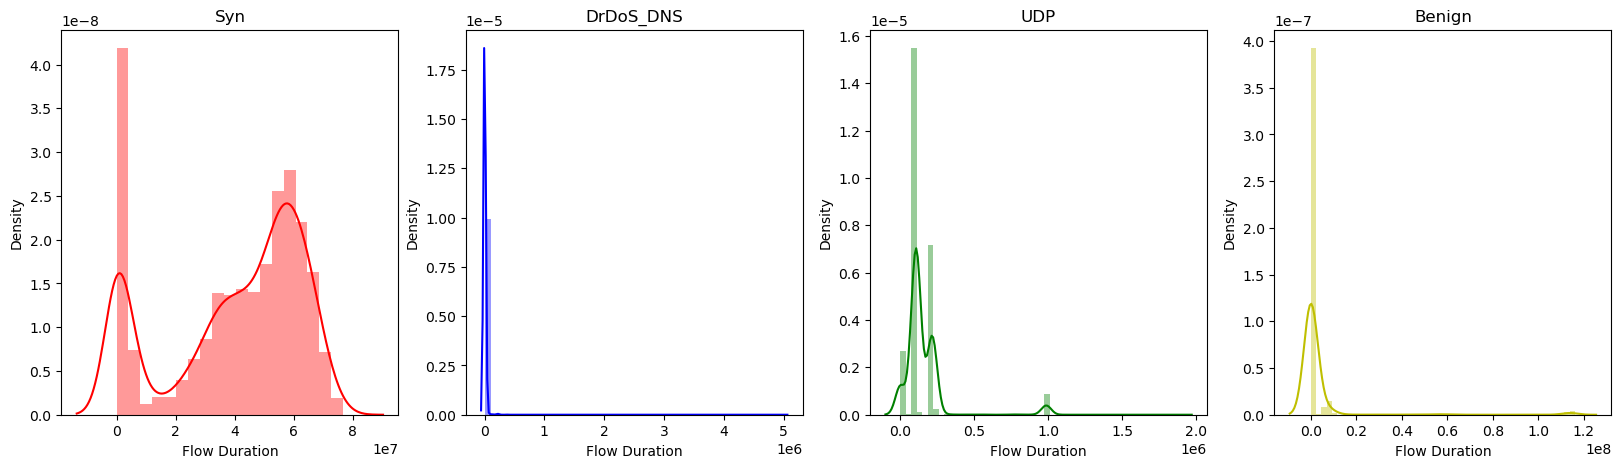

In [234]:
# Plot the distribution of the Flow Duration for each class
fig, ax = plt.subplots(1, 4, figsize=(20, 5))
sns.distplot(df[df['Label'] == 'Syn']['Flow Duration'], ax=ax[0], color='r')
ax[0].set_title('Syn')
sns.distplot(df[df['Label'] == 'DrDoS_DNS']['Flow Duration'], ax=ax[1], color='b')
ax[1].set_title('DrDoS_DNS')
sns.distplot(df[df['Label'] == 'UDP']['Flow Duration'], ax=ax[2], color='g')
ax[2].set_title('UDP')
sns.distplot(df[df['Label'] == 'Benign']['Flow Duration'], ax=ax[3], color='y')
ax[3].set_title('Benign')
plt.show()

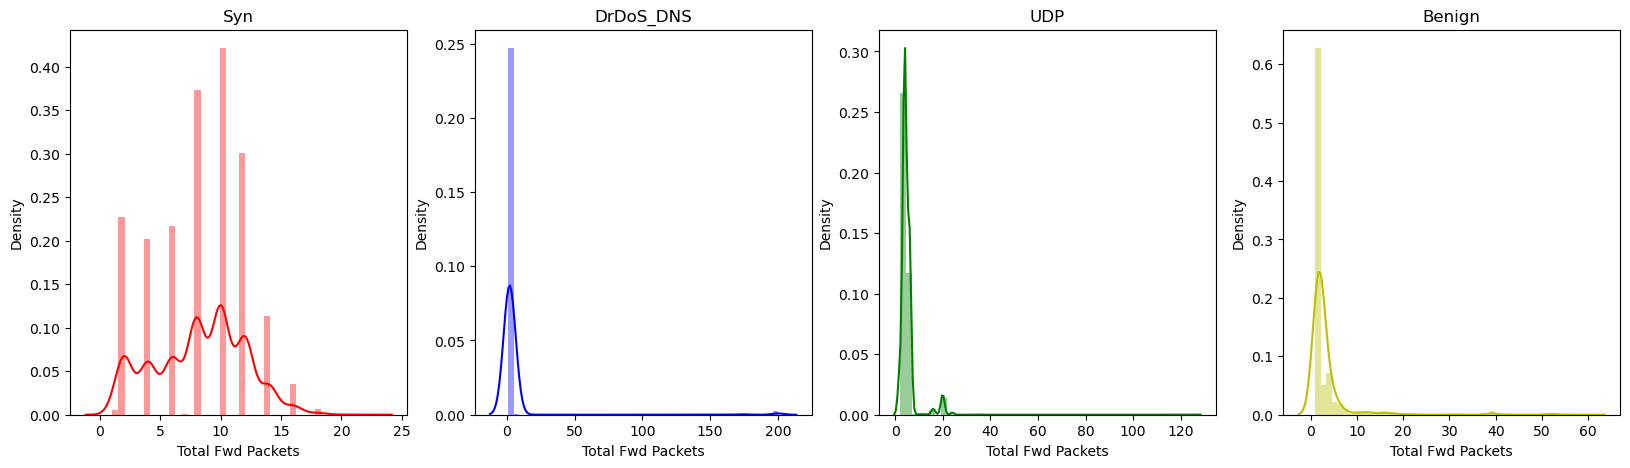

In [235]:
# Plot the distribution of the Total Fwd Packets for each class
fig, ax = plt.subplots(1, 4, figsize=(20, 5))
sns.distplot(df[df['Label'] == 'Syn']['Total Fwd Packets'], ax=ax[0], color='r')
ax[0].set_title('Syn')
sns.distplot(df[df['Label'] == 'DrDoS_DNS']['Total Fwd Packets'], ax=ax[1], color='b')
ax[1].set_title('DrDoS_DNS')
sns.distplot(df[df['Label'] == 'UDP']['Total Fwd Packets'], ax=ax[2], color='g')
ax[2].set_title('UDP')
sns.distplot(df[df['Label'] == 'Benign']['Total Fwd Packets'], ax=ax[3], color='y')
ax[3].set_title('Benign')
plt.show()

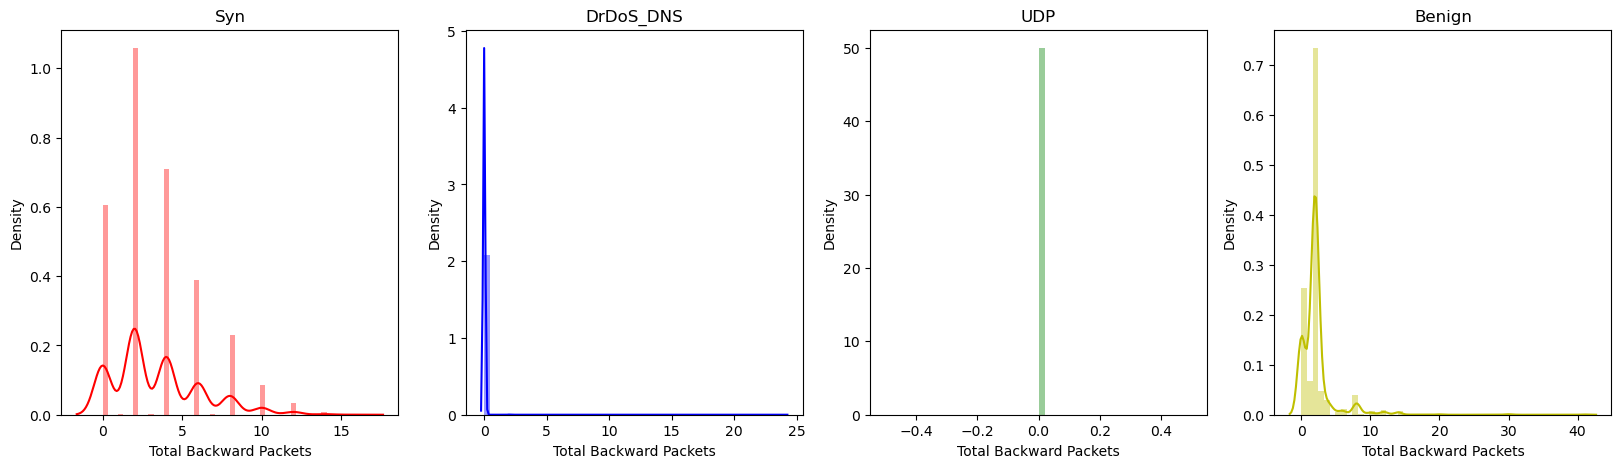

In [236]:
# Plot the distribution of the Total Backward Packets for each class
fig, ax = plt.subplots(1, 4, figsize=(20, 5))
sns.distplot(df[df['Label'] == 'Syn']['Total Backward Packets'], ax=ax[0], color='r')
ax[0].set_title('Syn')
sns.distplot(df[df['Label'] == 'DrDoS_DNS']['Total Backward Packets'], ax=ax[1], color='b')
ax[1].set_title('DrDoS_DNS')
sns.distplot(df[df['Label'] == 'UDP']['Total Backward Packets'], ax=ax[2], color='g')
ax[2].set_title('UDP')
sns.distplot(df[df['Label'] == 'Benign']['Total Backward Packets'], ax=ax[3], color='y')
ax[3].set_title('Benign')
plt.show()

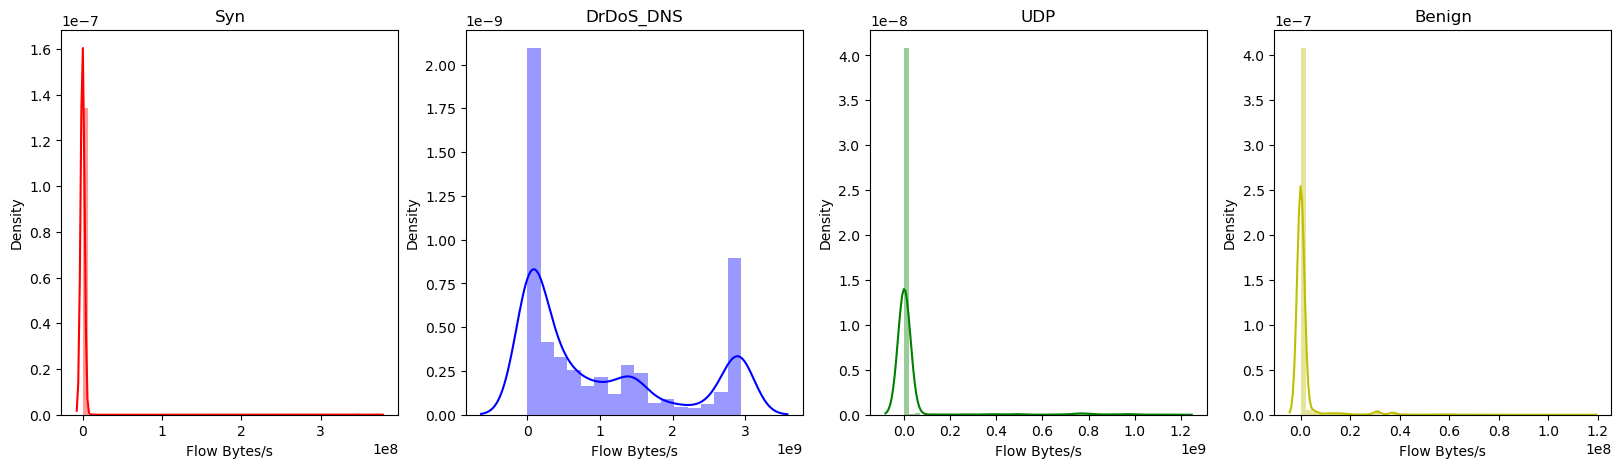

In [237]:
# Plot the distribution of the Flow Bytes/s for each class
fig, ax = plt.subplots(1, 4, figsize=(20, 5))
sns.distplot(df[df['Label'] == 'Syn']['Flow Bytes/s'], ax=ax[0], color='r')
ax[0].set_title('Syn')
sns.distplot(df[df['Label'] == 'DrDoS_DNS']['Flow Bytes/s'], ax=ax[1], color='b')
ax[1].set_title('DrDoS_DNS')
sns.distplot(df[df['Label'] == 'UDP']['Flow Bytes/s'], ax=ax[2], color='g') 
ax[2].set_title('UDP')
sns.distplot(df[df['Label'] == 'Benign']['Flow Bytes/s'], ax=ax[3], color='y')
ax[3].set_title('Benign')
plt.show()

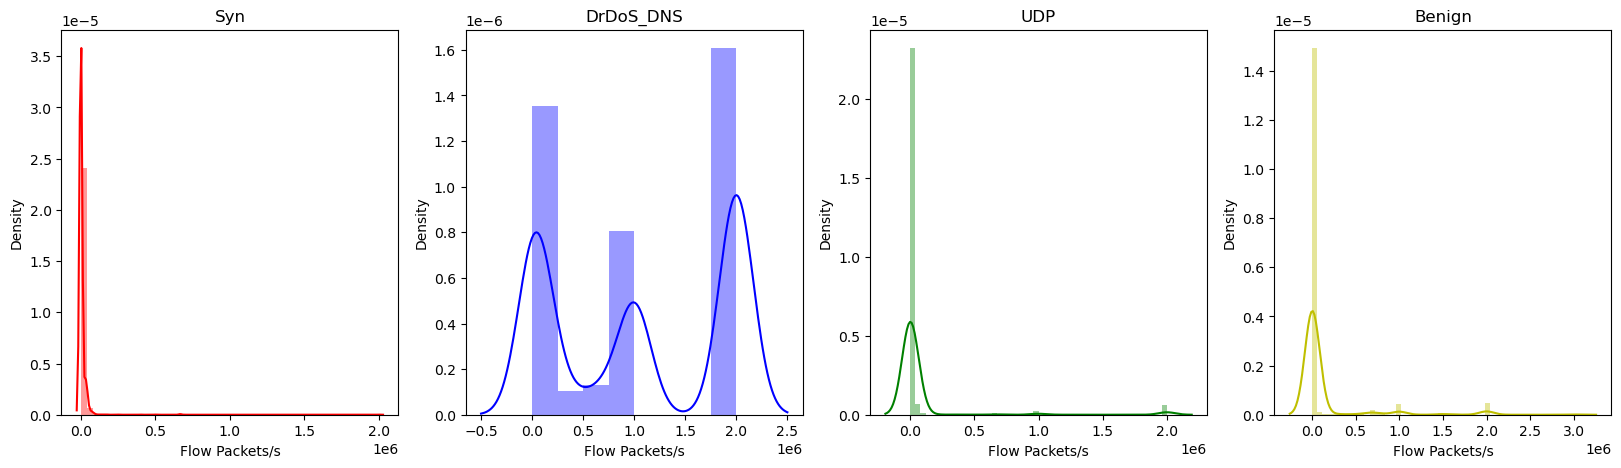

In [238]:
# Plot the distribution of the Flow Packets/s for each class
fig, ax = plt.subplots(1, 4, figsize=(20, 5))
sns.distplot(df[df['Label'] == 'Syn']['Flow Packets/s'], ax=ax[0], color='r')
ax[0].set_title('Syn')
sns.distplot(df[df['Label'] == 'DrDoS_DNS']['Flow Packets/s'], ax=ax[1], color='b')
ax[1].set_title('DrDoS_DNS')
sns.distplot(df[df['Label'] == 'UDP']['Flow Packets/s'], ax=ax[2], color='g')
ax[2].set_title('UDP')
sns.distplot(df[df['Label'] == 'Benign']['Flow Packets/s'], ax=ax[3], color='y')
ax[3].set_title('Benign')
plt.show()

We can see that the distribution of the Syn attack is very different from the other classes. The values can be very high when regarding the number of packets sent or the flow duration.
However, the DNS attack have some really different charasterisitcs to benign traffic. We can see that the Flow Bytes/s and Flow Packets/s are very high for the DNS attack.

These visualizations help us to have a better understanding of the characteristics of the attacks.

### Correlation matrix

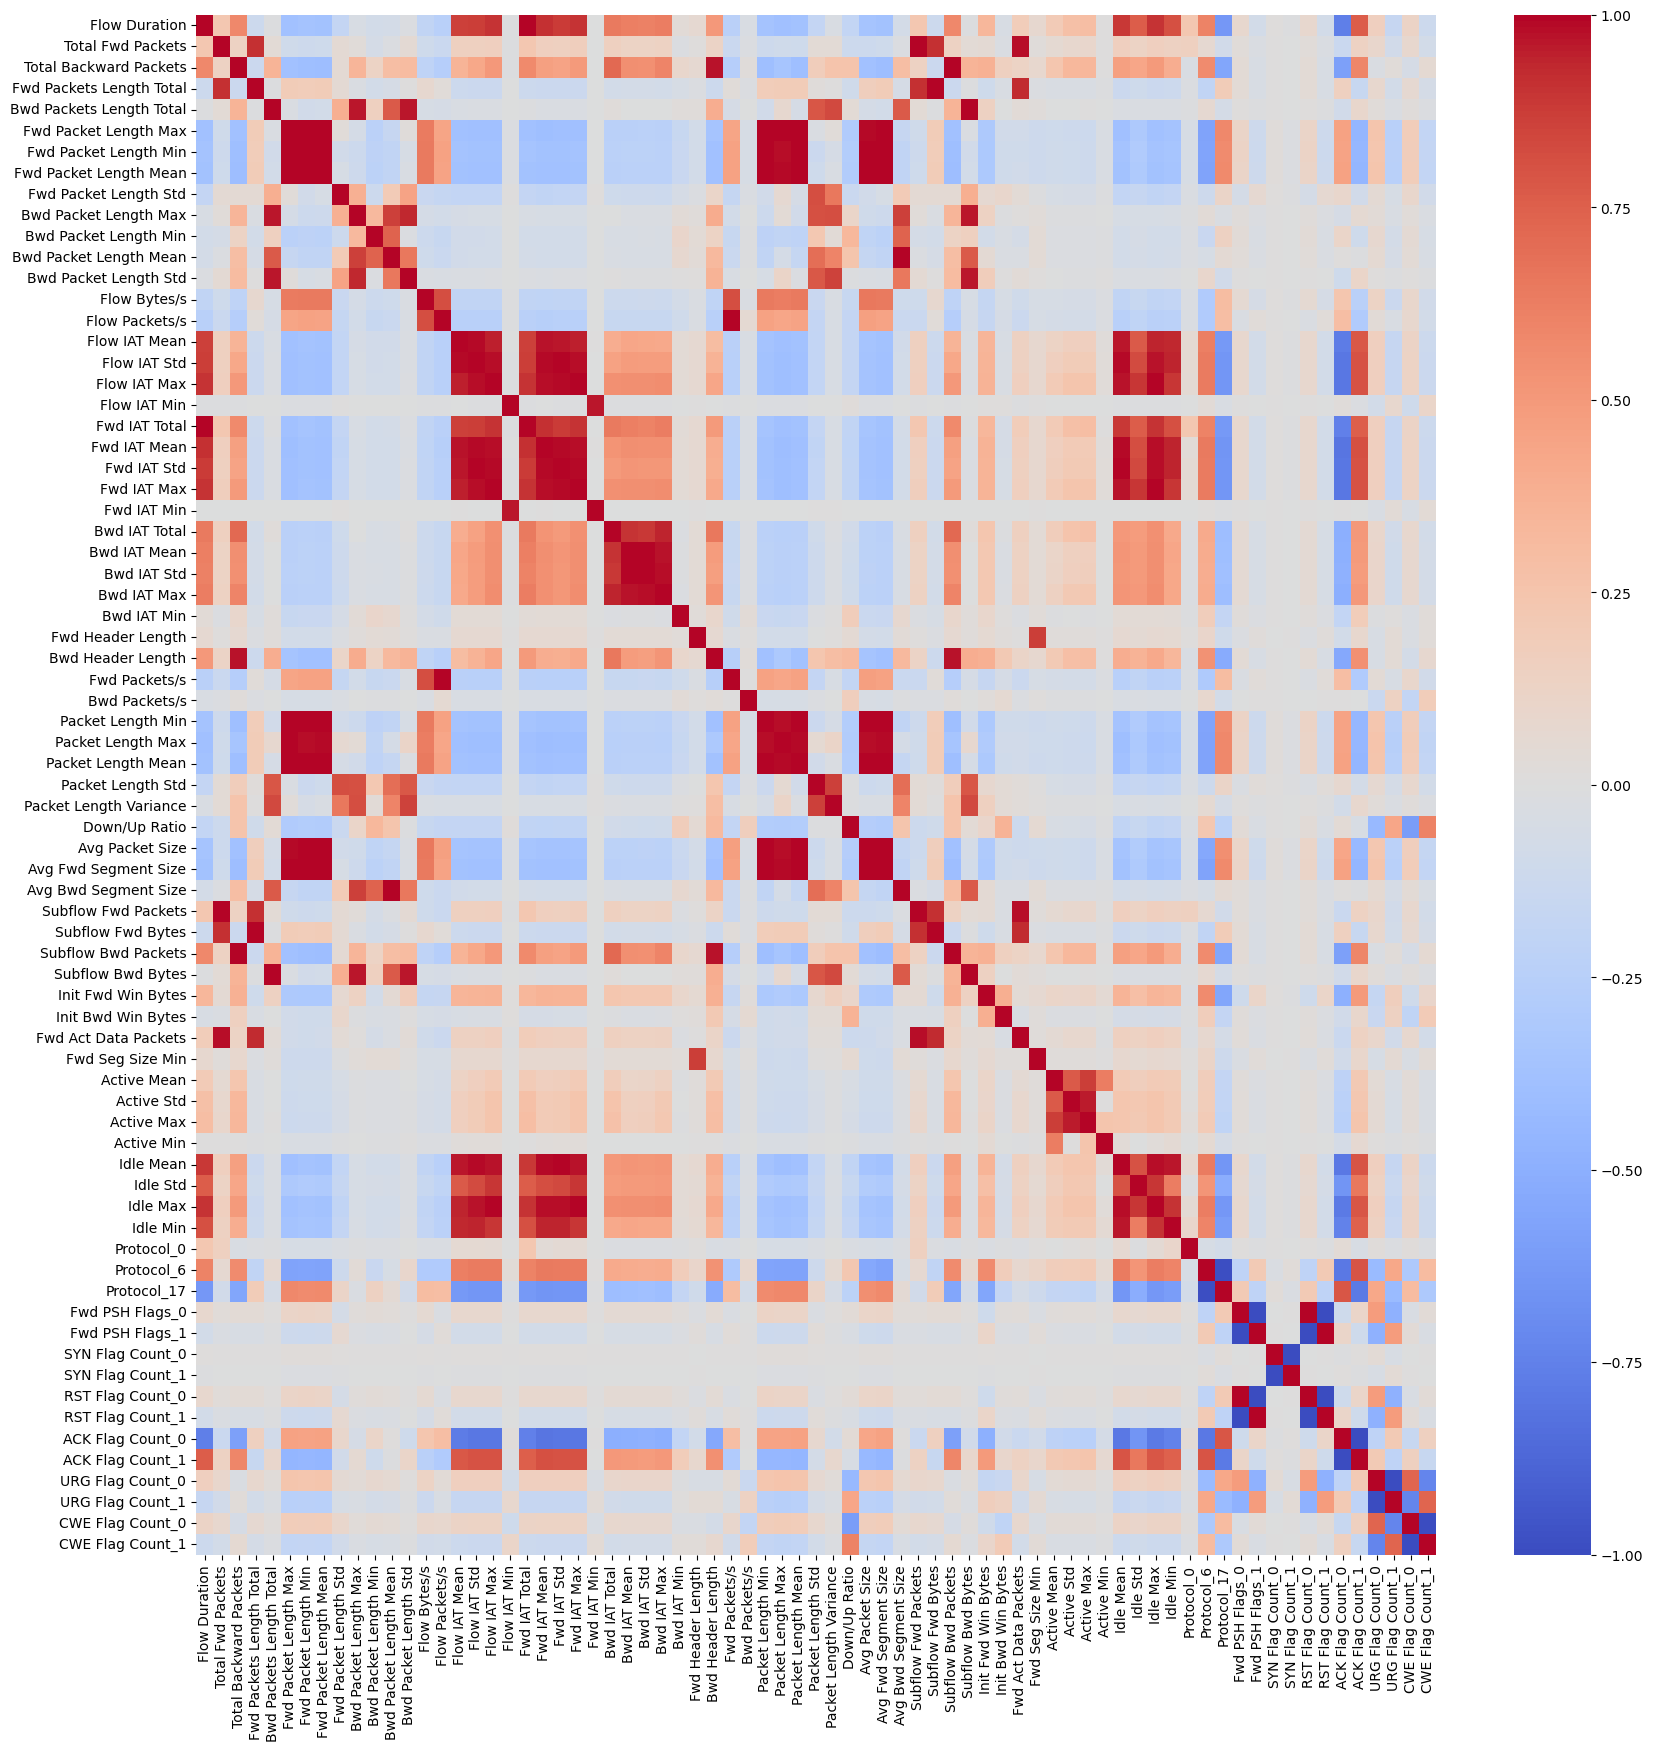

In [239]:
# Plot the correlation matrix
corr = df.corr()
plt.figure(figsize=(20, 20))
sns.heatmap(corr, annot=False, cmap='coolwarm')
plt.show()

We can see that we have high correlation between some features such as Packets Min/Max/Mean and Fwd Packets Min/Max/Mean, Idle Mean/Std/Min/Max and Flow IAT Mean/Std/Min/Max, etc. The OneHotEncoder has created some columns that are perfectly anti-correlated as we can see with the last columns.

The correlations will be handled by the PCA after the Scaling.

## Feature Dimensionality Reduction

### PCA

### Kernel PCA

### t-SNE

In [240]:
from sklearn.manifold import TSNE

# scatter plot the data
def plot_tsne(df_tsne):
    sns.scatterplot(x='PC1', y='PC2', hue='Label', data=df_tsne)
    plt.show()

[t-SNE] Computing 16 nearest neighbors...
[t-SNE] Indexed 13300 samples in 0.005s...
[t-SNE] Computed neighbors for 13300 samples in 0.801s...
[t-SNE] Computed conditional probabilities for sample 1000 / 13300
[t-SNE] Computed conditional probabilities for sample 2000 / 13300
[t-SNE] Computed conditional probabilities for sample 3000 / 13300
[t-SNE] Computed conditional probabilities for sample 4000 / 13300
[t-SNE] Computed conditional probabilities for sample 5000 / 13300
[t-SNE] Computed conditional probabilities for sample 6000 / 13300
[t-SNE] Computed conditional probabilities for sample 7000 / 13300
[t-SNE] Computed conditional probabilities for sample 8000 / 13300
[t-SNE] Computed conditional probabilities for sample 9000 / 13300
[t-SNE] Computed conditional probabilities for sample 10000 / 13300
[t-SNE] Computed conditional probabilities for sample 11000 / 13300
[t-SNE] Computed conditional probabilities for sample 12000 / 13300
[t-SNE] Computed conditional probabilities for sam

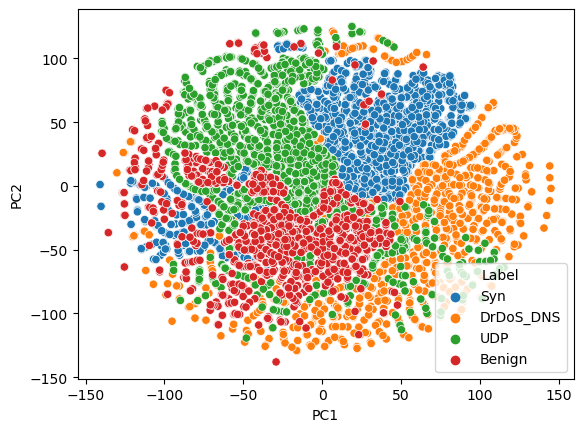

In [241]:
tsne = TSNE(n_components=2, verbose=1, random_state=123, perplexity=5)
df_tsne = pd.DataFrame(tsne.fit_transform(df.drop('Label', axis=1)), columns=['PC1', 'PC2'])
df_tsne['Label'] = df['Label'].values
plot_tsne(df_tsne)

We can see that the t-SNE algorithm is able to separate the different classes. However, the classes are not enough separated. We need to adjust the perplexity parameter in order to have a better separation.

According to this [article](https://towardsdatascience.com/how-to-tune-hyperparameters-of-tsne-7c0596a18868#:~:text=How%20to%20select%20optimal%20perplexity%3F), The optimal perplexity parameter depends on the number of samples in the dataset. As we have around 13k samples, we can try to set the perplexity to 100.

[t-SNE] Computing 301 nearest neighbors...
[t-SNE] Indexed 13300 samples in 0.005s...
[t-SNE] Computed neighbors for 13300 samples in 0.890s...
[t-SNE] Computed conditional probabilities for sample 1000 / 13300
[t-SNE] Computed conditional probabilities for sample 2000 / 13300
[t-SNE] Computed conditional probabilities for sample 3000 / 13300
[t-SNE] Computed conditional probabilities for sample 4000 / 13300
[t-SNE] Computed conditional probabilities for sample 5000 / 13300
[t-SNE] Computed conditional probabilities for sample 6000 / 13300
[t-SNE] Computed conditional probabilities for sample 7000 / 13300
[t-SNE] Computed conditional probabilities for sample 8000 / 13300
[t-SNE] Computed conditional probabilities for sample 9000 / 13300
[t-SNE] Computed conditional probabilities for sample 10000 / 13300
[t-SNE] Computed conditional probabilities for sample 11000 / 13300
[t-SNE] Computed conditional probabilities for sample 12000 / 13300
[t-SNE] Computed conditional probabilities for sa

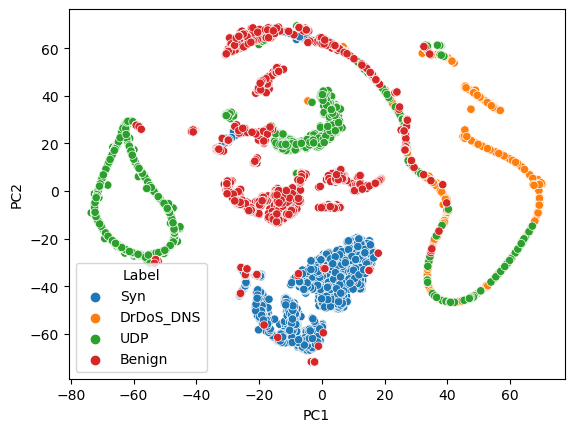

In [242]:
tsne = TSNE(n_components=2, verbose=1, random_state=123, perplexity=100)
df_tsne = pd.DataFrame(tsne.fit_transform(df.drop('Label', axis=1)), columns=['PC1', 'PC2'])
df_tsne['Label'] = df['Label'].values
plot_tsne(df_tsne)

The result looks very good with a perplexity of 100. We can see that the classes are well separated. We only have more difficulty to separate the UDP attacks and Benign traffic. And the UDP attacks are not well separated from the DrDos DNS attacks. The Syn attacks are well separated from the other classes.

Without the Benign traffic, we can see that the clusters are well separated.

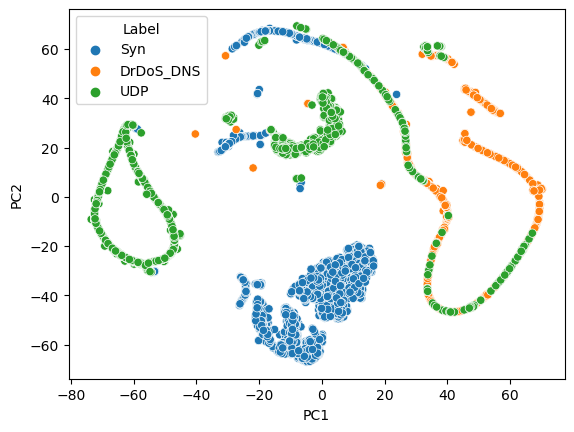

In [249]:
df_tsne_no_benign = df_tsne[df_tsne['Label'] != 'Benign']
plot_tsne(df_tsne_no_benign)

## Supervised learning for multiclassification

### Data Splitting

## Unsupservised learning for clustering

### k-Means

In [290]:
from sklearn.cluster import KMeans

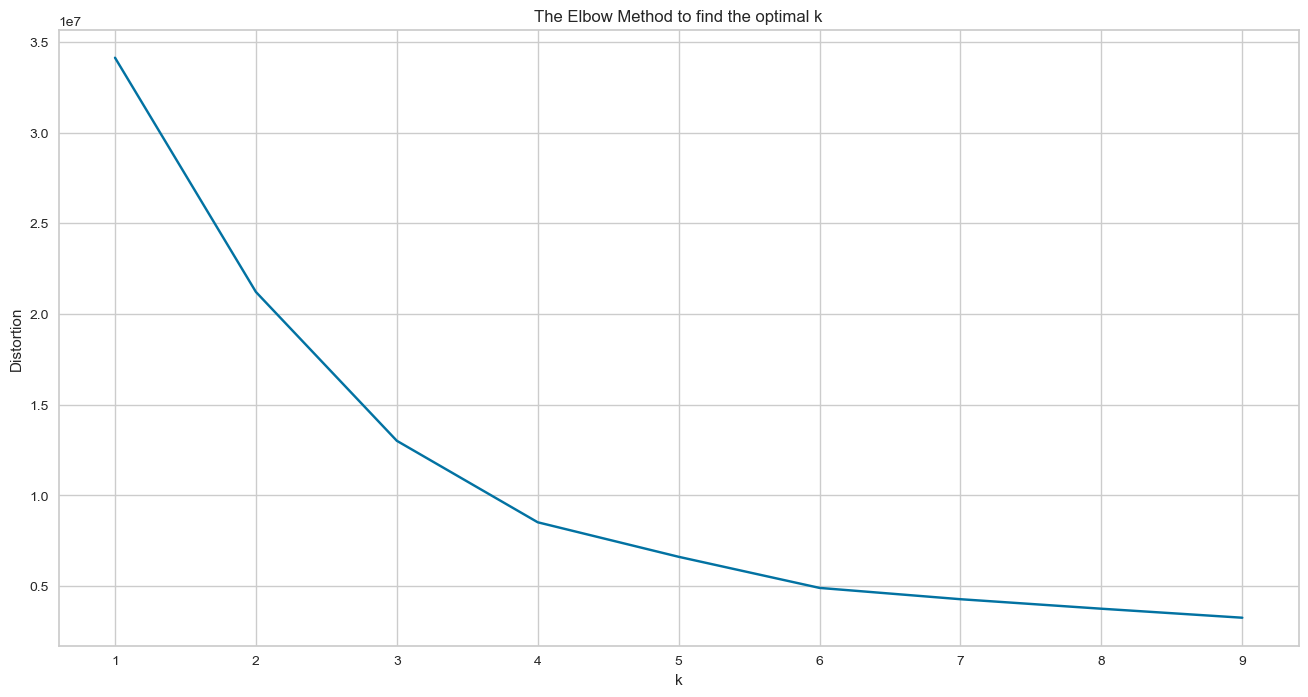

In [291]:
# elbow method to choose the number of clusters
distortions = []
K = range(1, 10)
for k in K:
    kmeanModel = KMeans(n_clusters=k, random_state=123)
    kmeanModel.fit(df_tsne.drop('Label', axis=1))
    distortions.append(kmeanModel.inertia_)

plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method to find the optimal k')
plt.show()

According to the elbow method, the optimal number of clusters is 4, which is coherent with the number of classes in the dataset.

In [292]:
# create kmeans object
N = 4
kmeans = KMeans(n_clusters=N, random_state=123)

# fit kmeans object to data
kmeans.fit(df_tsne[['PC1', 'PC2']])

# print location of clusters learned by kmeans object
print(kmeans.cluster_centers_)

[[ 46.342186    -7.88625   ]
 [-52.370766    -0.47800708]
 [  1.5079248   40.83255   ]
 [ -4.2258763  -36.283867  ]]


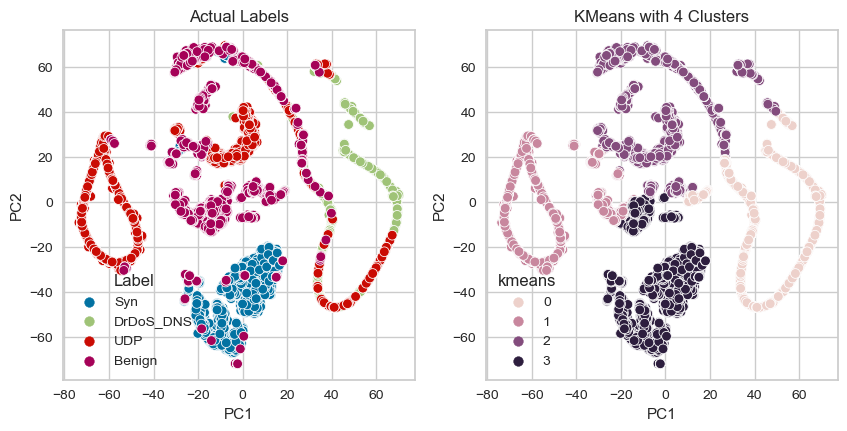

In [293]:
# plot the data and the clusters learned
df_tsne['kmeans'] = kmeans.labels_
fig = plt.figure(figsize=(10, 10))
plt.subplot(221)
sns.scatterplot(x='PC1', y='PC2', hue='Label', data=df_tsne)
plt.title('Actual Labels')
plt.subplot(222)
sns.scatterplot(x='PC1', y='PC2', hue='kmeans', data=df_tsne)
plt.title('KMeans with {} Clusters'.format(N))
plt.show()

We can see that k-means is not able to separate the data into the correct clusters. This is because the shape of the k-means' clusters is always spherical, and it looks for clusters of equal variance, which in this case, is not the case.

We will try to use the k-means algorithm with the t-SNE results without the Benign traffic.

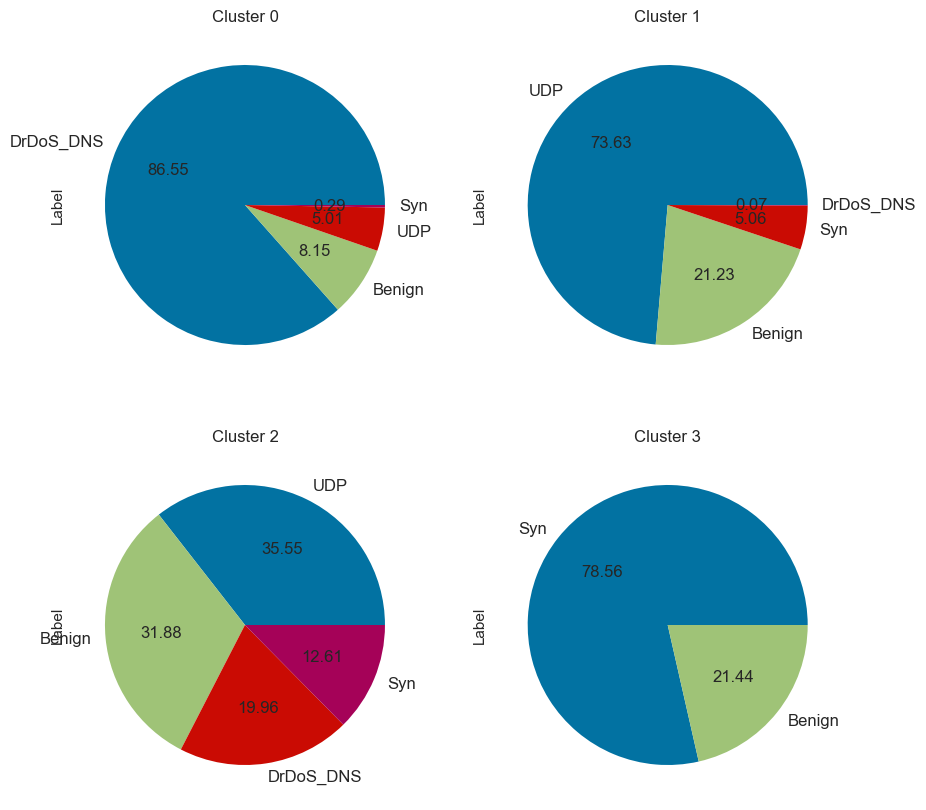

In [294]:
# create a plot grid of 2x2
fig, ax = plt.subplots(2, 2, figsize=(10, 10))
# plot the pie charts of distributions of labels for each cluster
for i in range(4):
    df_tsne[df_tsne['kmeans'] == i]['Label'].value_counts().plot.pie(ax=ax[i//2][i%2], autopct='%.2f', fontsize=12)
    ax[i//2][i%2].set_title('Cluster {}'.format(i))
plt.show()

We can see that 3 of the 4 clusters are almost fully constituted of one class.

We still have trouble to separate the Benign traffic from the attacks as the Benign traffic is mixed among the 4 clusters.

0.43532935


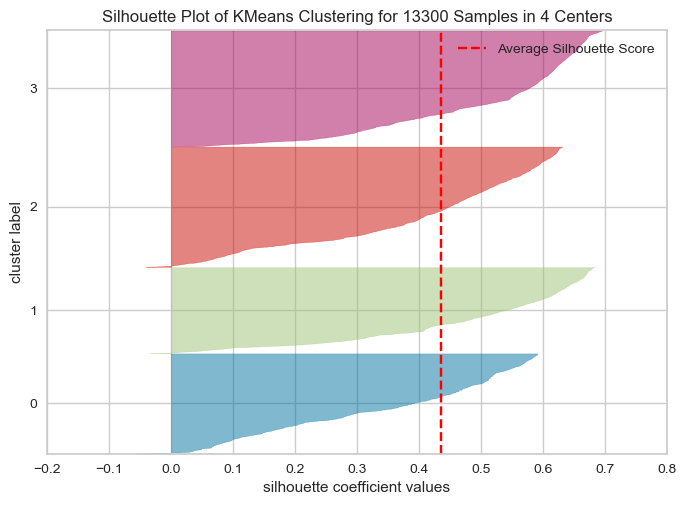

<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 13300 Samples in 4 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [295]:
# evaluate the performance of the clustering using the silouette score
from sklearn.metrics import silhouette_score
print(silhouette_score(df_tsne[['PC1', 'PC2']], kmeans.labels_))

# plot the silhouette for the various clusters
from yellowbrick.cluster import SilhouetteVisualizer
visualizer = SilhouetteVisualizer(kmeans, colors='yellowbrick')
visualizer.fit(df_tsne[['PC1', 'PC2']])
visualizer.show()

The silhouette plot is a graphical tool presenting how well our data points fit into the clusters they’ve been assigned to and how well they would fit into other clusters. The silhouette coefficient is a measure of cluster cohesion and separation.